In [1]:
%matplotlib inline


# Creating MNE objects from data arrays


In this simple example, the creation of MNE objects from
numpy arrays is demonstrated. In the last example case, a
NEO file format is used as a source for the data.



In [2]:
# Author: Jaakko Leppakangas <jaeilepp@student.jyu.fi>
#
# License: BSD (3-clause)

import numpy as np
import neo

import mne

print(__doc__)

Automatically created module for IPython interactive environment


Create arbitrary data



In [3]:
sfreq = 1000  # Sampling frequency
times = np.arange(0, 10, 0.001)  # Use 10000 samples (10s)

sin = np.sin(times * 10)  # Multiplied by 10 for shorter cycles
cos = np.cos(times * 10)
sinX2 = sin * 2
cosX2 = cos * 2

# Numpy array of size 4 X 10000.
data = np.array([sin, cos, sinX2, cosX2])

# Definition of channel types and names.
ch_types = ['mag', 'mag', 'grad', 'grad']
ch_names = ['sin', 'cos', 'sinX2', 'cosX2']

Create an :class:`info <mne.Info>` object.



In [4]:
# It is also possible to use info from another raw object.
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

Create a dummy :class:`mne.io.RawArray` object



Creating RawArray with float64 data, n_channels=4, n_times=10000
Current compensation grade : 0
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.


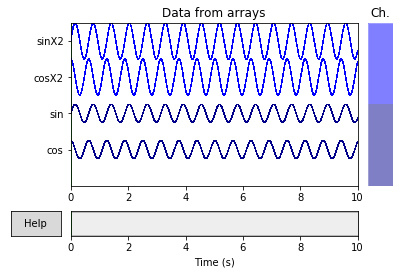

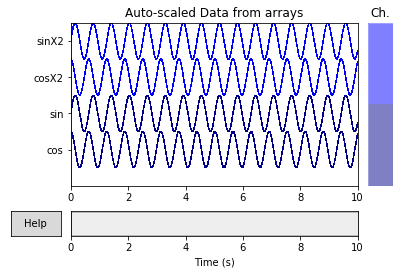

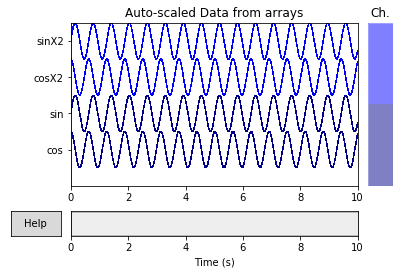

In [5]:
raw = mne.io.RawArray(data, info)

# Scaling of the figure.
# For actual EEG/MEG data different scaling factors should be used.
scalings = {'mag': 2, 'grad': 2}

raw.plot(n_channels=4, scalings=scalings, title='Data from arrays',
         show=True, block=True)

# It is also possible to auto-compute scalings
scalings = 'auto'  # Could also pass a dictionary with some value == 'auto'
raw.plot(n_channels=4, scalings=scalings, title='Auto-scaled Data from arrays',
         show=True, block=True)

EpochsArray



3 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


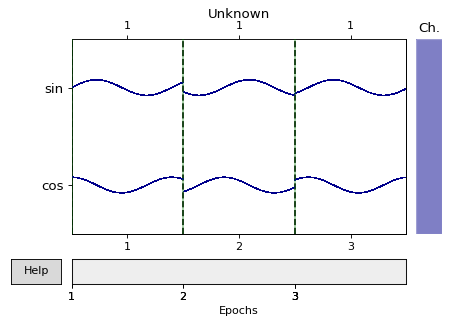

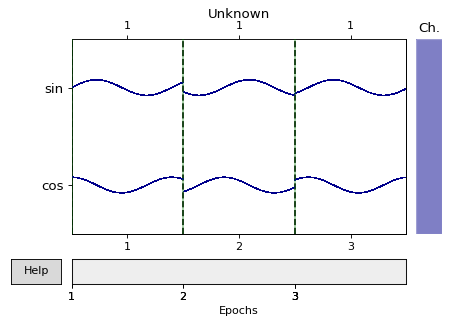

In [6]:
event_id = 1  # This is used to identify the events.
# First column is for the sample number.
events = np.array([[200, 0, event_id],
                   [1200, 0, event_id],
                   [2000, 0, event_id]])  # List of three arbitrary events

# Here a data set of 700 ms epochs from 2 channels is
# created from sin and cos data.
# Any data in shape (n_epochs, n_channels, n_times) can be used.
epochs_data = np.array([[sin[:700], cos[:700]],
                        [sin[1000:1700], cos[1000:1700]],
                        [sin[1800:2500], cos[1800:2500]]])

ch_names = ['sin', 'cos']
ch_types = ['mag', 'mag']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

epochs = mne.EpochsArray(epochs_data, info=info, events=events,
                         event_id={'arbitrary': 1})

picks = mne.pick_types(info, meg=True, eeg=False, misc=False)

epochs.plot(picks=picks, scalings='auto', show=True, block=True)

EvokedArray



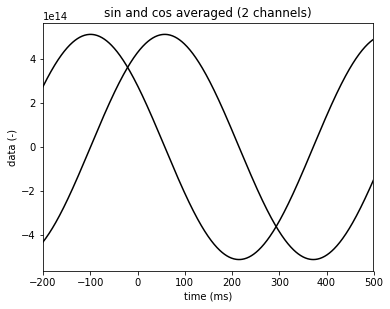

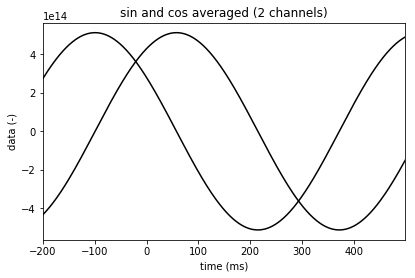

In [7]:
nave = len(epochs_data)  # Number of averaged epochs
evoked_data = np.mean(epochs_data, axis=0)

evokeds = mne.EvokedArray(evoked_data, info=info, tmin=-0.2,
                          comment='Arbitrary', nave=nave)
evokeds.plot(picks=picks, show=True, units={'mag': '-'},
             titles={'mag': 'sin and cos averaged'})

Create epochs by windowing the raw data.



[[   0    0    1]
 [1000    0    1]
 [2000    0    1]
 [3000    0    1]
 [4000    0    1]
 [5000    0    1]
 [6000    0    1]
 [7000    0    1]
 [8000    0    1]
 [9000    0    1]]
10 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 991 original time points ...
0 bad epochs dropped
Loading data for 10 events and 991 original time points ...
Loading data for 10 events and 991 original time points ...


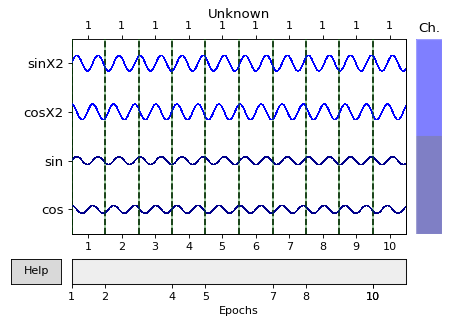

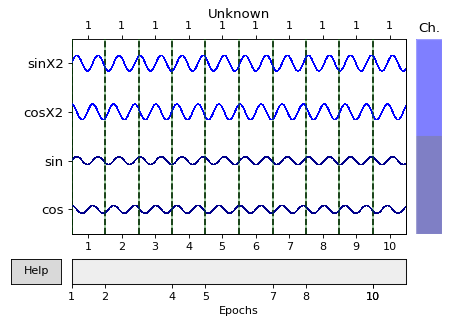

In [8]:
# The events are spaced evenly every 1 second.
duration = 1.

# create a fixed size events array
# start=0 and stop=None by default
events = mne.make_fixed_length_events(raw, event_id, duration=duration)
print(events)

# for fixed size events no start time before and after event
tmin = 0.
tmax = 0.99  # inclusive tmax, 1 second epochs

# create :class:`Epochs <mne.Epochs>` object
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=None, verbose=True)
epochs.plot(scalings='auto', block=True)

Create overlapping epochs using :func:`mne.make_fixed_length_events` (50 %
overlap). This also roughly doubles the amount of events compared to the
previous event list.



[[   0    0    1]
 [ 500    0    1]
 [1000    0    1]
 [1500    0    1]
 [2000    0    1]
 [2500    0    1]
 [3000    0    1]
 [3500    0    1]
 [4000    0    1]
 [4500    0    1]
 [5000    0    1]
 [5500    0    1]
 [6000    0    1]
 [6500    0    1]
 [7000    0    1]
 [7500    0    1]
 [8000    0    1]
 [8500    0    1]
 [9000    0    1]
 [9500    0    1]]
20 matching events found
No baseline correction applied
0 projection items activated
Loading data for 20 events and 991 original time points ...
1 bad epochs dropped
Loading data for 19 events and 991 original time points ...
Loading data for 19 events and 991 original time points ...


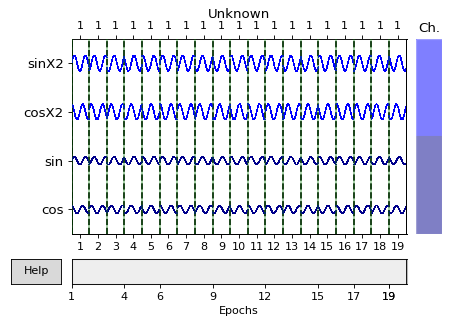

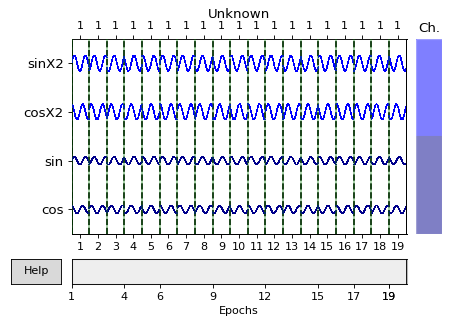

In [9]:
duration = 0.5
events = mne.make_fixed_length_events(raw, event_id, duration=duration)
print(events)
epochs = mne.Epochs(raw, events=events, tmin=tmin, tmax=tmax, baseline=None,
                    verbose=True)
epochs.plot(scalings='auto', block=True)

Extracting data from NEO file



In [11]:
# The example here uses the ExampleIO object for creating fake data.
# For actual data and different file formats, consult the NEO documentation.
reader = neo.io.ExampleIO('fakedata.nof')
bl = reader.read(cascade=True, lazy=False)[0]

# Get data from first (and only) segment
seg = bl.segments[0]
title = seg.file_origin

ch_names = list()
data = list()
for asig in seg.analogsignals:
    # Since the data does not contain channel names, channel indices are used.
    ch_names.append(str(asig.channel_index))
    asig = asig.rescale('V').magnitude
    data.append(asig)

sfreq = int(seg.analogsignals[0].sampling_rate.magnitude)

# By default, the channel types are assumed to be 'misc'.
info = mne.create_info(ch_names=ch_names, sfreq=sfreq)

raw = mne.io.RawArray(data, info)
raw.plot(n_channels=4, scalings={'misc': 1}, title='Data from NEO',
         show=True, block=True, clipping='clamp')

RuntimeError: Channel names are not unique, found duplicates for: set(['None'])